# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need? in thin the
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

### Download missing libraries
Comment in the following two lines in case some of the libraries cannot be imported. Please restart the kernel after download+upgrade has successfully finished

In [1]:
'''
### Download libraries
%pip install uproot
%pip install awkward
%pip install mplhep
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install tensorflow
%pip install sklearn
%pip install lmfit
### Upgrade libraries to latest version
%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade
'''


'\n### Download libraries\n%pip install uproot\n%pip install awkward\n%pip install mplhep\n%pip install numpy\n%pip install matplotlib\n%pip install scipy\n%pip install tensorflow\n%pip install sklearn\n%pip install lmfit\n### Upgrade libraries to latest version\n%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade\n'

### Import libraries

In [2]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
import json
import sympy as sy

## *Example*: Reading a ROOT.TTree and plotting a variable with a cut
We will open data and Monte Carlo samples using **uproot**. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

You can find more info on uproot following the references:
* Github repo: https://github.com/scikit-hep/uproot4
* Tutorial: https://masonproffitt.github.io/uproot-tutorial/
* Video tutorial on uproot and awkward arrays:  https://www.youtube.com/embed/ea-zYLQBS4U 

First, let's specify the folder path for both data and Monte Carlo (MC) samples

In [3]:
## Take folder with samples from Google Drive
#%pip install google-colab
#from google.colab import drive
#import os
#samplefolder = drive.mount('samples')
#path_data = 'samples/data/'
path_mc = './opal_data/mc/'
path_data = './opal_data/data/'

### Open the file introducing file path
file_ee = uproot.open(path_mc+'ee.root')
file_mm = uproot.open(path_mc+'mm.root')
file_tt = uproot.open(path_mc+'tt.root')
file_qq = uproot.open(path_mc+'qq.root')
file_data = uproot.open(path_data+'daten_5.root')

ttree_name = 'myTTree'

## Load branches
mc_ee = file_ee[ttree_name].arrays()
mc_mm = file_mm[ttree_name].arrays()
mc_tt = file_tt[ttree_name].arrays()
mc_qq = file_qq[ttree_name].arrays()
data  = file_data[ttree_name].arrays()
del file_ee, file_mm, file_tt, file_qq, file_data

mc_ee = ak.to_numpy(mc_ee)
mc_mm = ak.to_numpy(mc_mm)
mc_tt = ak.to_numpy(mc_tt)
mc_qq = ak.to_numpy(mc_qq)
data  = ak.to_numpy(data)

mc_ee = np.array([np.array(mc_ee[i].tolist(),dtype=np.float32) for i in range(len(mc_ee))])
mc_mm = np.array([np.array(mc_mm[i].tolist(),dtype=np.float32) for i in range(len(mc_mm))])
mc_tt = np.array([np.array(mc_tt[i].tolist(),dtype=np.float32) for i in range(len(mc_tt))])
mc_qq = np.array([np.array(mc_qq[i].tolist(),dtype=np.float32) for i in range(len(mc_qq))])
data  = np.array([np.array(data[i].tolist(),dtype=np.float32) for i in range(len(data))])


# Create the Full array and the Labels to identify every event
#0->ee ; 1->mm ; 2->tt ; 3->hh
mc_all = np.concatenate((mc_ee,mc_mm,mc_tt,mc_qq))
ML_Labels = np.concatenate((   np.array([0]*len(mc_ee)), np.array([1]*len(mc_mm)), np.array([2]*len(mc_tt)), np.array([3]*len(mc_qq))  ))
ML_Labels_Cat = keras.utils.to_categorical(ML_Labels , num_classes=4)

# making some dictionaries and constants to ease the data handling
Types = {0:[mc_ee,"Electrons","g"], 1:[mc_mm,"Muons","b"], 2:[mc_tt,"Taus","c"], 3:[mc_qq,"Quarks","r"], 4:[mc_all,"All",'k']}
Nametable = {'Run':0, 'Event':1, 'Ncharged':2, 'Pcharged':3, 'E_ecal':4, 'E_hcal':5, 'E_lep':6, 'Cos_thru':7, 'Cos_thet':8 }
Outfolder ="./MPL_Model/"

The last line shows all the variables available in the TTree to carry out the experiment. The meaning of these is described in the following table

| Variable name | Description |
| --- | --- | 
| <pre>run</pre> | Run number |
| <pre>event</pre> | Event number |
| <pre>Ncharged</pre> | Number of charged tracks |
| <pre>Pcharged</pre> | Total scalar sum of track momenta |
| <pre>E_ecal</pre> | Total energy measured in the electromagnetic calorimeter |
| <pre>E_hcal</pre> | Total energy measured in the hadronic calorimete |
| <pre>E_lep</pre> | LEP beam energy (=$\sqrt{s}/2$) |
| <pre>cos_thru</pre> | cosine of the polar angle between beam axis and thrust axis |
| <pre>cos_thet</pre> | cosine of the polar angle between incoming positron and outgoing positive particle |

We proceed to plot *PCharged* for illustration.

### Make a plot with a certain selection

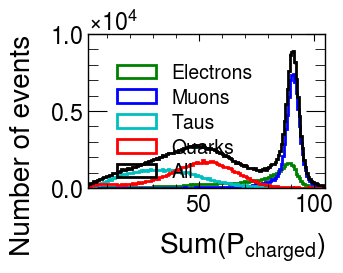

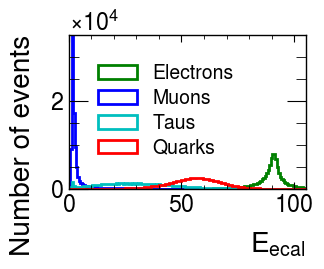

In [4]:
def plotting(variable, xmin, xmax, ymin, ymax, xlabel="X Var", ylabel="Y Var" ,plotall=True):
    "Function to Plot any variable on the .root from just one line"
    plt.figure(figsize=(3,2))
    binning = round(np.sqrt(len(Types[0][0][:,variable])))
    rang = 4
    if plotall: rang=5
    for i in range(rang):
        bin_content, bin_edges, _ = plt.hist(Types[i][0][:,variable],bins=binning,range=(0.,200.), histtype='step',  linewidth=2, edgecolor=Types[i][2], label=Types[i][1],    density=False)
    mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars
    error_sizes = np.sqrt(bin_content)
    plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none')

    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=2)
    plt.show()


plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 

plotting(Nametable["Pcharged"],2.,105.,0.,10000,'$Sum(P_{charged})$', 'Number of events', plotall=True)
plotting(Nametable["E_ecal"],0.,105.,0.,35000,'$E_{ecal}$', 'Number of events', plotall=False)

# DNN Multi-Class Classification Model Training
*we only needed to run this code one time to generate and train the network

## Model Application

In [5]:
# Here we load and apply the already trained model
Model = keras.models.load_model(Outfolder)
Response = Model.predict(mc_all[:,[2,3,4,5,7,8]], verbose=0)
ResponseData = Model.predict(data[:,[2,3,4,5,7,8]], verbose=0)

## Ploting the DNN Results and calculating the efficiency

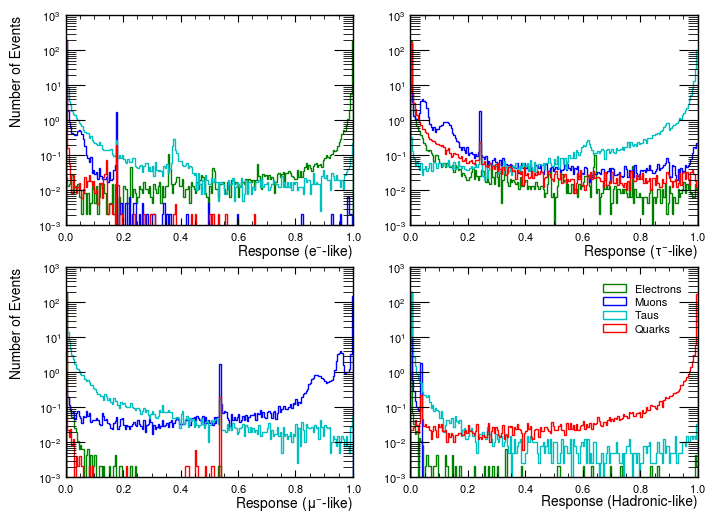

In [6]:
# In very loose words:
# From the mc data we trained the model to output the % of certainty of a given event to be part of the ee, mm, tt and hh categories
# For example, an event can have the following result (0.2, 0.8, 0.85, 0.1), meaning that it is likely an mm or a tt event
# after applying the model we have to choose the order and value on wich we cut to separate their contributions 

# We plot the model results (Responses)
fig, axs = plt.subplots(2, 2)
for i in range(4):
    axs[0, 0].hist(Response[ML_Labels==i][:,0],bins=200,range=(0,1), linewidth=1, density=True,color=Types[i][2], label=Types[i][1], histtype='step')
    axs[0, 0].set_yscale('log')
    axs[0, 0].tick_params(labelsize=8)
    axs[0, 0].set_xlabel(r"Response ($e^{-}$-like)", fontsize=10)
    axs[0, 0].set_ylabel("Number of Events", fontsize=10)
    axs[0, 0].xaxis.set_label_coords(1.0, -0.08)


    axs[1, 0].hist(Response[ML_Labels==i][:,1],bins=200,range=(0,1), linewidth=1, density=True,color=Types[i][2], label=Types[i][1], histtype='step')
    axs[1, 0].set_yscale('log')
    axs[1, 0].tick_params(labelsize=8)
    axs[1, 0].set_xlabel(r"Response ($\mu^{-}$-like)", fontsize=10)
    axs[1, 0].set_ylabel("Number of Events", fontsize=10)
    axs[1, 0].xaxis.set_label_coords(1.0, -0.08)

    axs[0, 1].hist(Response[ML_Labels==i][:,2],bins=200,range=(0,1), linewidth=1, density=True,color=Types[i][2], label=Types[i][1], histtype='step')
    axs[0, 1].set_yscale('log')
    axs[0, 1].tick_params(labelsize=8)
    axs[0, 1].set_xlabel(r"Response ($\tau^{-}$-like)", fontsize=10)
    axs[0, 1].xaxis.set_label_coords(1.0, -0.08)

    axs[1, 1].hist(Response[ML_Labels==i][:,3],bins=200,range=(0,1), linewidth=1, density=True,color=Types[i][2], label=Types[i][1], histtype='step')
    axs[1, 1].set_yscale('log')
    axs[1, 1].tick_params(labelsize=8)
    axs[1, 1].set_xlabel(r"Response (Hadronic-like)", fontsize=10)
    axs[1, 1].xaxis.set_label_coords(1.0, -0.08)

plt.legend(prop={'size': 8})
#fig.tight_layout()
plt.show()

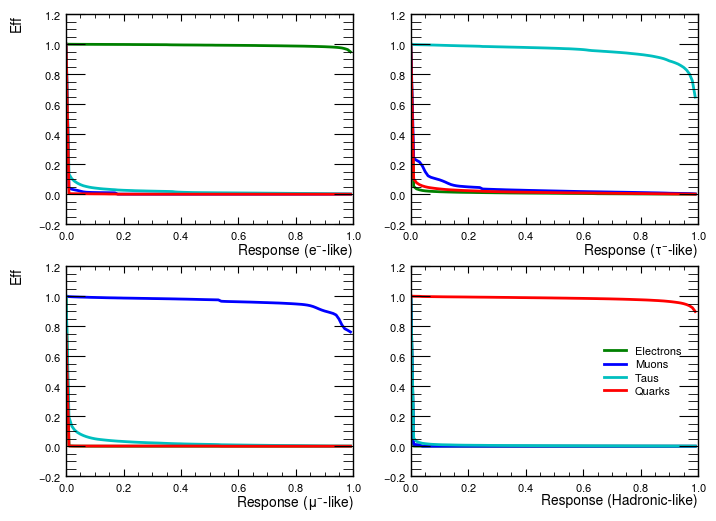

Hadron Cut (N. Events):
 True Possitive=98019 ; False Possitive=542 ; False Negative=544
Efficiency=0.9945
purity=0.9945
lost Events=544 -> 0.55%


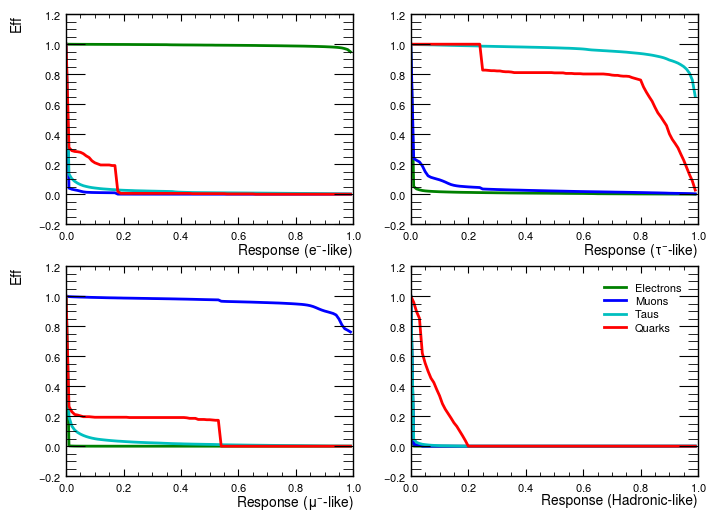

In [7]:
# Now we need to determine the cut values and the order on which we are going to cut
def efficiencycalc(responses,labels,Responsetype):         #0->ee ; 1->mm ; 2->tt ; 3->hh
    SavedEff = {"Electrons":np.array([]),"Muons":np.array([]),"Taus":np.array([]),"Quarks":np.array([]),"FalsePossitives":np.array([])}
    Current_ee = responses[labels==0][:,Responsetype]
    initial_ee = len(Current_ee)

    Current_mm = responses[labels==1][:,Responsetype]
    initial_mm = len(Current_mm)

    Current_tt = responses[labels==2][:,Responsetype]
    initial_tt = len(Current_tt)

    Current_hh = responses[labels==3][:,Responsetype]
    initial_hh = len(Current_hh)
    for i in rangeX:
        Current_ee = Current_ee[Current_ee>i]
        Current_mm = Current_mm[Current_mm>i]
        Current_tt = Current_tt[Current_tt>i]
        Current_hh = Current_hh[Current_hh>i]
        SavedEff["Electrons"] = np.append(SavedEff["Electrons"], len(Current_ee)/initial_ee)
        SavedEff["Muons"] = np.append(SavedEff["Muons"], len(Current_mm)/initial_mm)
        SavedEff["Taus"] = np.append(SavedEff["Taus"], len(Current_tt)/initial_tt)
        SavedEff["Quarks"] = np.append(SavedEff["Quarks"], len(Current_hh)/initial_hh)
        if Responsetype==0:
            SavedEff["FalsePossitives"] = np.append(SavedEff["FalsePossitives"], (len(Current_mm)+len(Current_tt)+len(Current_hh))/(initial_mm+initial_tt+initial_hh) )
        if Responsetype==1:
            SavedEff["FalsePossitives"] = np.append(SavedEff["FalsePossitives"], (len(Current_ee)+len(Current_tt)+len(Current_hh))/(initial_ee+initial_tt+initial_hh) )
        if Responsetype==2:
            SavedEff["FalsePossitives"] = np.append(SavedEff["FalsePossitives"], (len(Current_ee)+len(Current_mm)+len(Current_hh))/(initial_ee+initial_mm+initial_hh) )
        if Responsetype==3:
            SavedEff["FalsePossitives"] = np.append(SavedEff["FalsePossitives"], (len(Current_ee)+len(Current_mm)+len(Current_tt))/(initial_ee+initial_mm+initial_tt) )


    return SavedEff

def plotall(array1, array2, array3, array4):
    fig2, axs2 = plt.subplots(2, 2)
    for i in range(4):
        axs2[0, 0].plot(rangeX, array1[Types[i][1]], color=Types[i][2], label=Types[i][1])
        axs2[0, 0].tick_params(labelsize=8)
        axs2[0, 0].set_xlabel(r"Response ($e^{-}$-like)", fontsize=10)
        axs2[0, 0].set_ylabel("Eff", fontsize=10)
        axs2[0, 0].xaxis.set_label_coords(1.0, -0.08)

        axs2[1, 0].plot(rangeX, array2[Types[i][1]], color=Types[i][2], label=Types[i][1])
        axs2[1, 0].tick_params(labelsize=8)
        axs2[1, 0].set_xlabel(r"Response ($\mu^{-}$-like)", fontsize=10)
        axs2[1, 0].set_ylabel("Eff", fontsize=10)
        axs2[1, 0].xaxis.set_label_coords(1.0, -0.08)

        axs2[0, 1].plot(rangeX, array3[Types[i][1]], color=Types[i][2], label=Types[i][1])
        axs2[0, 1].tick_params(labelsize=8)
        axs2[0, 1].set_xlabel(r"Response ($\tau^{-}$-like)", fontsize=10)
        axs2[0, 1].xaxis.set_label_coords(1.0, -0.08)

        axs2[1, 1].plot(rangeX, array4[Types[i][1]], color=Types[i][2], label=Types[i][1])
        axs2[1, 1].tick_params(labelsize=8)
        axs2[1, 1].set_xlabel(r"Response (Hadronic-like)", fontsize=10)
        axs2[1, 1].xaxis.set_label_coords(1.0, -0.08)

    plt.legend(prop={'size': 8})
    plt.show()

rangeX = np.arange(0.0,1.0,0.01)
ee_eff = efficiencycalc(Response,ML_Labels,0)
mm_eff = efficiencycalc(Response,ML_Labels,1)
tt_eff = efficiencycalc(Response,ML_Labels,2)
hh_eff = efficiencycalc(Response,ML_Labels,3)

plotall(ee_eff,mm_eff,tt_eff,hh_eff)

# the Hadron cut is clearly the easiest one to do, thus its better to do first (this way, events that would be categorized as hh will not be present at all in the other cuts)

'''To Look for Hadron Cut'''  # here I'm just ploting the true possitives/false positives to choose the cut value (the plot is not really interesting so I let it commented)
#for i in range(len(rangeX)):
#    print([round(rangeX[i],3), round(hh_eff[Types[3][1]][i],5), round(hh_eff["FalsePossitives"][i],5)]) # round(hh_eff[Types[3][1]][i]/hh_eff["FalsePossitives"][i],5)
#plt.plot(rangeX,hh_eff[Types[3][1]]/hh_eff["FalsePossitives"])
#plt.axvline(0.32, ls="--", color="k")
#plt.show()

condition_hh = Response[:,3]>=0.20
True_poss = len(ML_Labels[condition_hh][ML_Labels[condition_hh]==3])    # Should be categorized as a Hadron and is categorized as a Hadron
False_poss = len(ML_Labels[condition_hh][ML_Labels[condition_hh]!=3])   # Should be categorized as something else but is categorized as a Hadron
False_neg = len(ML_Labels[np.invert(condition_hh)][ML_Labels[np.invert(condition_hh)]==3]) # Should be categorized as a Hadron but it is categorized as something else
print("Hadron Cut (N. Events):\n True Possitive={} ; False Possitive={} ; False Negative={}".format(True_poss, False_poss, False_neg))
print("Efficiency={:.4f}".format((True_poss/(True_poss+False_neg))))
print("purity={:.4f}".format(1-(False_poss/True_poss) ))
print("lost Events={} -> {:.2f}%".format(False_neg,(False_neg/(True_poss+False_neg)*100)))


'''After Hadron Cut'''
#0->ee ; 1->mm ; 2->tt ; 3->hh
ee_eff_1 = efficiencycalc(Response[np.invert(condition_hh)],ML_Labels[np.invert(condition_hh)],0)
mm_eff_1 = efficiencycalc(Response[np.invert(condition_hh)],ML_Labels[np.invert(condition_hh)],1)
tt_eff_1 = efficiencycalc(Response[np.invert(condition_hh)],ML_Labels[np.invert(condition_hh)],2)
hh_eff_1 = efficiencycalc(Response[np.invert(condition_hh)],ML_Labels[np.invert(condition_hh)],3)
plotall(ee_eff_1,mm_eff_1,tt_eff_1,hh_eff_1)

Electron Cut (N. Events):
 True Possitive=92893 ; False Possitive=561 ; False Negative=909
Efficiency=0.9903%
purity=0.9940%
lost Events=909 -> 0.97%


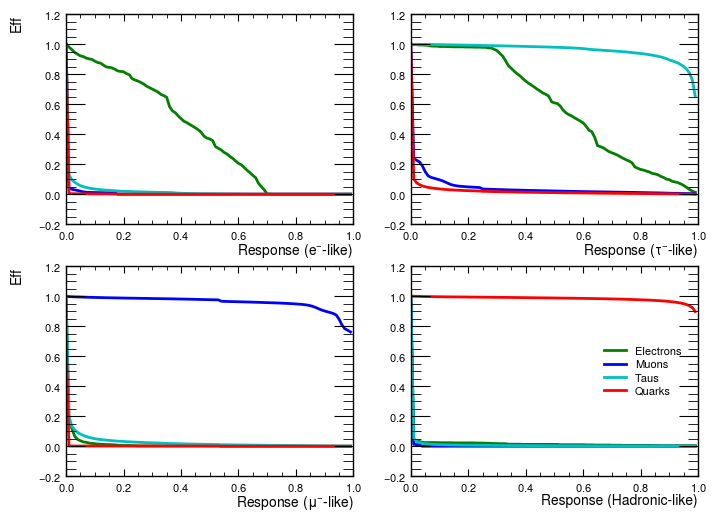

In [8]:
'''To Look for Electron Cut'''
#for i in range(len(rangeX)):
#    print([round(rangeX[i],3), round(ee_eff_1[Types[0][1]][i],5), round(ee_eff_1["FalsePossitives"][i],5)])
#plt.plot(rangeX,ee_eff_1[Types[0][1]]/ee_eff_1["FalsePossitives"])
#plt.axvline(0.35, ls="--", color="k")
#plt.show()

condition_ee = np.bitwise_and(np.invert(condition_hh), Response[:,0]>=0.7)
True_poss = len(ML_Labels[condition_ee][ML_Labels[condition_ee]==0])
False_poss = len(ML_Labels[condition_ee][ML_Labels[condition_ee]!=0])
False_neg = len(ML_Labels[np.invert(condition_ee)][ML_Labels[np.invert(condition_ee)]==0])
print("Electron Cut (N. Events):\n True Possitive={} ; False Possitive={} ; False Negative={}".format(True_poss, False_poss, False_neg))
print("Efficiency={:.4f}%".format((True_poss/(True_poss+False_neg))))
print("purity={:.4f}%".format(1-(False_poss/True_poss) ))
print("lost Events={} -> {:.2f}%".format(False_neg,(False_neg/(True_poss+False_neg)*100)))


'''After Electron Cut'''
#0->ee ; 1->mm ; 2->tt ; 3->hh
ee_eff_2 = efficiencycalc(Response[np.invert(condition_ee)],ML_Labels[np.invert(condition_ee)],0)
mm_eff_2 = efficiencycalc(Response[np.invert(condition_ee)],ML_Labels[np.invert(condition_ee)],1)
tt_eff_2 = efficiencycalc(Response[np.invert(condition_ee)],ML_Labels[np.invert(condition_ee)],2)
hh_eff_2 = efficiencycalc(Response[np.invert(condition_ee)],ML_Labels[np.invert(condition_ee)],3)
plotall(ee_eff_2,mm_eff_2,tt_eff_2,hh_eff_2)


Muon Cut (N. Events):
 True Possitive=93209 ; False Possitive=2589 ; False Negative=1172
Efficiency=0.9876
purity=0.9722
lost Events=1172 -> 1.24%


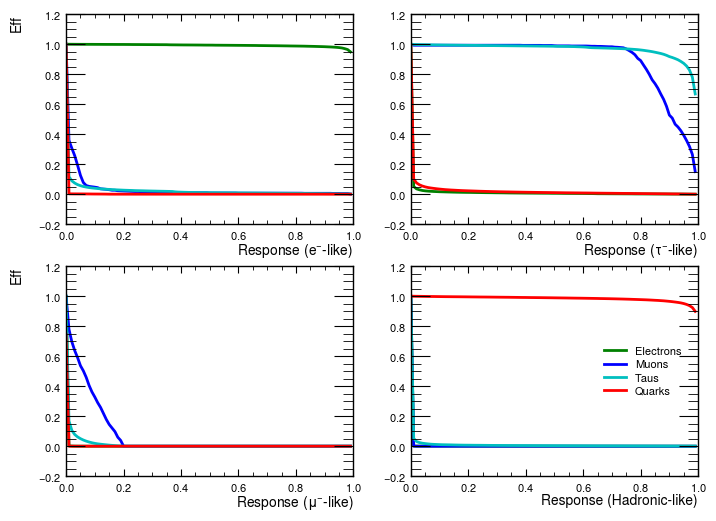

In [9]:
'''To Look for Muons Cut'''
#for i in range(len(rangeX)):
#    print([round(rangeX[i],3), round(mm_eff_2[Types[1][1]][i],5), round(mm_eff_2["FalsePossitives"][i],5)])
#plt.plot(rangeX,mm_eff_2[Types[0][1]]/mm_eff_2["FalsePossitives"])
#plt.axvline(0.7, ls="--", color="k")
#plt.show()


condition_mm = np.bitwise_and(np.invert(condition_ee), Response[:,1]>=0.2)
True_poss = len(ML_Labels[condition_mm][ML_Labels[condition_mm]==1])
False_poss = len(ML_Labels[condition_mm][ML_Labels[condition_mm]!=1])
False_neg = len(ML_Labels[np.invert(condition_mm)][ML_Labels[np.invert(condition_mm)]==1])
print("Muon Cut (N. Events):\n True Possitive={} ; False Possitive={} ; False Negative={}".format(True_poss, False_poss, False_neg))
print("Efficiency={:.4f}".format((True_poss/(True_poss+False_neg))))
print("purity={:.4f}".format(1-(False_poss/True_poss) ))
print("lost Events={} -> {:.2f}%".format(False_neg,(False_neg/(True_poss+False_neg)*100)))


'''After Muon Cut'''
#0->ee ; 1->mm ; 2->tt ; 3->hh
ee_eff_3 = efficiencycalc(Response[np.invert(condition_mm)],ML_Labels[np.invert(condition_mm)],0)
mm_eff_3 = efficiencycalc(Response[np.invert(condition_mm)],ML_Labels[np.invert(condition_mm)],1)
tt_eff_3 = efficiencycalc(Response[np.invert(condition_mm)],ML_Labels[np.invert(condition_mm)],2)
hh_eff_3 = efficiencycalc(Response[np.invert(condition_mm)],ML_Labels[np.invert(condition_mm)],3)
plotall(ee_eff_3,mm_eff_3,tt_eff_3,hh_eff_3)


In [10]:
'''To Look for Tau Cut'''
#for i in range(len(rangeX)):
#    print([round(rangeX[i],3), round(tt_eff_3[Types[2][1]][i],5), round(tt_eff_3["FalsePossitives"][i],5)])
#plt.plot(rangeX,tt_eff_3[Types[2][1]]/tt_eff_3["FalsePossitives"])
#plt.axvline(0.56, ls="--", color="k")
#plt.show()


condition_tt = np.bitwise_and(np.invert(condition_mm), Response[:,2]>=0.42)
True_poss = len(ML_Labels[condition_tt][ML_Labels[condition_tt]==2])
False_poss = len(ML_Labels[condition_tt][ML_Labels[condition_tt]!=2])
False_neg = len(ML_Labels[np.invert(condition_tt)][ML_Labels[np.invert(condition_tt)]==2])
print("Tau Cut (N. Events):\n True Possitive={} ; False Possitive={} ; False Negative={}".format(True_poss, False_poss, False_neg))
print("Efficiency={:.4f}%".format((True_poss/(True_poss+False_neg))))
print("purity={:.4f}%".format(1-(False_poss/True_poss) ))
print("lost Events={} -> {:.2f}%".format(False_neg,(False_neg/(True_poss+False_neg)*100)))


'''After Tau Cut'''
#0->ee ; 1->mm ; 2->tt ; 3->hh
ee_eff_4 = efficiencycalc(Response[np.invert(condition_tt)],ML_Labels[np.invert(condition_tt)],0)
mm_eff_4 = efficiencycalc(Response[np.invert(condition_tt)],ML_Labels[np.invert(condition_tt)],1)
tt_eff_4 = efficiencycalc(Response[np.invert(condition_tt)],ML_Labels[np.invert(condition_tt)],2)
hh_eff_4 = efficiencycalc(Response[np.invert(condition_tt)],ML_Labels[np.invert(condition_tt)],3)
#plotall(ee_eff_4,mm_eff_4,tt_eff_4,hh_eff_4)




Tau Cut (N. Events):
 True Possitive=75817 ; False Possitive=3063 ; False Negative=3397
Efficiency=0.9571%
purity=0.9596%
lost Events=3397 -> 4.29%


Total: 201446
conditions:
Selected Electrons: 24845
Selected Muons: 7781
Selected Taus: 9810
Selected Hadrons: 160351
Physical Cut Electrons: 26200
Physical Cut Muons: 40602
Physical Cut Tau: 13610
Physical Cut Hadrons: 152603


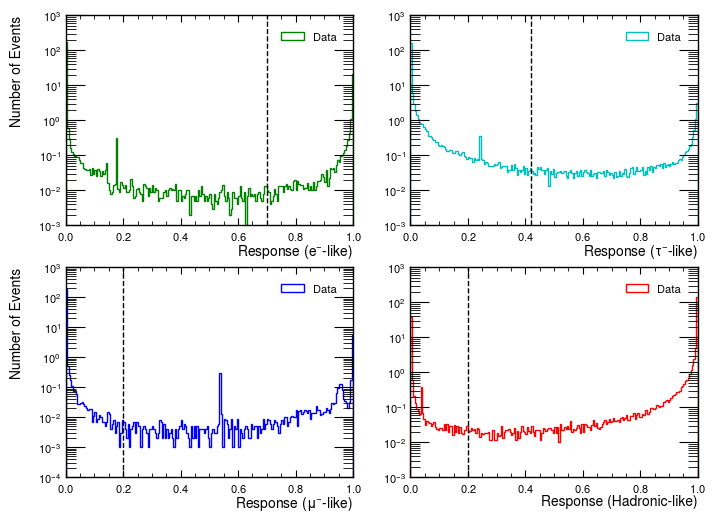

In [11]:
print("Total: {}".format(len(ResponseData[:,0])))
condition_hh_dat = ResponseData[:,3]>=0.20
condition_ee_dat = np.bitwise_and(np.invert(condition_hh_dat), ResponseData[:,0]>=0.7)
condition_mm_dat = np.bitwise_and(np.invert(condition_ee_dat), ResponseData[:,1]>=0.2)
condition_tt_dat = np.bitwise_and(np.invert(condition_mm_dat), ResponseData[:,2]>=0.42)

print("conditions:")
print("Selected Electrons: {}".format(len(data[condition_ee_dat])))
print("Selected Muons: {}".format(len(data[condition_mm_dat])))
print("Selected Taus: {}".format(len(data[condition_tt_dat])))
print("Selected Hadrons: {}".format(len(data[condition_hh_dat])))

print("Physical Cut Electrons: {}".format(len(
        data[np.bitwise_and(
             data[:,Nametable["E_ecal"]]>=65,
             data[:,Nametable["Ncharged"]]<10
             )]
        )))
print("Physical Cut Muons: {}".format(len(
        data[np.bitwise_and(
             data[:,Nametable["Pcharged"]]>=65,
             data[:,Nametable["E_ecal"]]<75,
             data[:,Nametable["Ncharged"]]<10
             )]
        )))

print("Physical Cut Tau: {}".format(len(
        data[np.bitwise_and(np.bitwise_and(
            data[:,Nametable["Pcharged"]]<80,
            data[:,Nametable["E_ecal"]]<75),
            np.bitwise_and(
            data[:,Nametable["E_ecal"]]>=5,
            data[:,Nametable["Ncharged"]]<10
            ))]
        )))
print("Physical Cut Hadrons: {}".format(len(
            data[data[:,Nametable["Ncharged"]]>10]
        )))

# We plot the model results (Responses)
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(ResponseData[:,0],bins=200,range=(0,1), linewidth=1, density=True,color=Types[0][2], label="Data", histtype='step')
axs[0, 0].set_yscale('log')
axs[0, 0].tick_params(labelsize=8)
axs[0, 0].set_xlabel(r"Response ($e^{-}$-like)", fontsize=10)
axs[0, 0].set_ylabel("Number of Events", fontsize=10)
axs[0, 0].xaxis.set_label_coords(1.0, -0.08)
axs[0, 0].legend(prop={'size': 8})
axs[0, 0].axvline(0.7, linewidth=1, color="k", ls="--")

axs[1, 0].hist(ResponseData[:,1],bins=200,range=(0,1), linewidth=1, density=True,color=Types[1][2], label="Data", histtype='step')
axs[1, 0].set_yscale('log')
axs[1, 0].tick_params(labelsize=8)
axs[1, 0].set_xlabel(r"Response ($\mu^{-}$-like)", fontsize=10)
axs[1, 0].set_ylabel("Number of Events", fontsize=10)
axs[1, 0].xaxis.set_label_coords(1.0, -0.08)
axs[1, 0].legend(prop={'size': 8})
axs[1, 0].axvline(0.2, linewidth=1, color="k", ls="--")


axs[0, 1].hist(ResponseData[:,2],bins=200,range=(0,1), linewidth=1, density=True,color=Types[2][2], label="Data", histtype='step')
axs[0, 1].set_yscale('log')
axs[0, 1].tick_params(labelsize=8)
axs[0, 1].set_xlabel(r"Response ($\tau^{-}$-like)", fontsize=10)
axs[0, 1].xaxis.set_label_coords(1.0, -0.08)
axs[0, 1].legend(prop={'size': 8})
axs[0, 1].axvline(0.42, linewidth=1, color="k", ls="--")


axs[1, 1].hist(ResponseData[:,3],bins=200,range=(0,1), linewidth=1, density=True,color=Types[3][2], label="Data", histtype='step')
axs[1, 1].set_yscale('log')
axs[1, 1].tick_params(labelsize=8)
axs[1, 1].set_xlabel(r"Response (Hadronic-like)", fontsize=10)
axs[1, 1].xaxis.set_label_coords(1.0, -0.08)
axs[1, 1].legend(prop={'size': 8})
axs[1, 1].axvline(0.2, linewidth=1, color="k", ls="--")


#fig.tight_layout()
plt.show()


In [70]:
# Calculation of Efficiency, Background and Error Matrices
from IPython.display import display, Math, Latex
effcy_matrix = np.zeros((4,4))
bkg_matrix = np.zeros((4,4))
error_matrix = np.zeros((4,4))
conditions = [condition_ee,condition_mm,condition_tt,condition_hh]
for i in range (4):
    for j in range(4):
        part_mask = ML_Labels==i
        k = len(ML_Labels[conditions[j]][part_mask[conditions[j]]])
        n = 100000
        val = k/n # efficiency
        bkg_mask = ML_Labels==j
        val2 = len(ML_Labels[conditions[i]][bkg_mask[conditions[i]]])/len(ML_Labels[conditions[i]]) #Get Background
#         val3 = 0
#         if val!=0: val3 = val*np.sqrt( 1./val + 1./100000.) # Error of efficiency - Poisson
        val3 = np.sqrt((k+1)*(k+2)/((n+2)*(n+3)) - (k+1)**2/(n+2)**2) # Error of efficiency - Bayesian
        effcy_matrix[j][i] =val
        bkg_matrix[j][i] = val2
        error_matrix[j][i] = val3

aux_effM = sy.Matrix(effcy_matrix)
aux_bkgM = sy.Matrix(bkg_matrix)
aux_errM = sy.Matrix(error_matrix)
display(Math("\\textrm{Efficiency} =" + sy.latex(sy.N(aux_effM,4))))
display(Math("\\textrm{Background} =" + sy.latex(sy.N(aux_bkgM,4))))
display(Math("\\textrm{Uncertainty(Stat)} =" + sy.latex(sy.N(aux_errM,4))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

24845


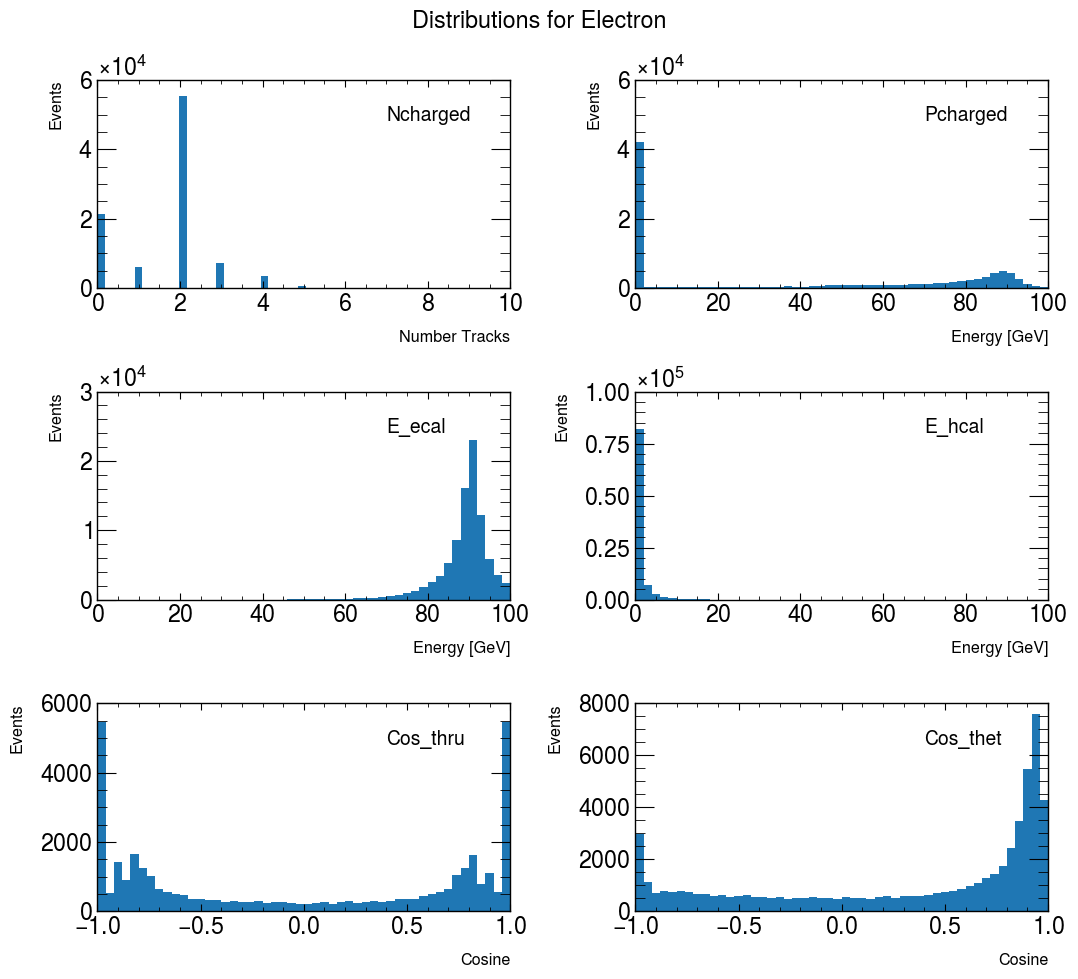

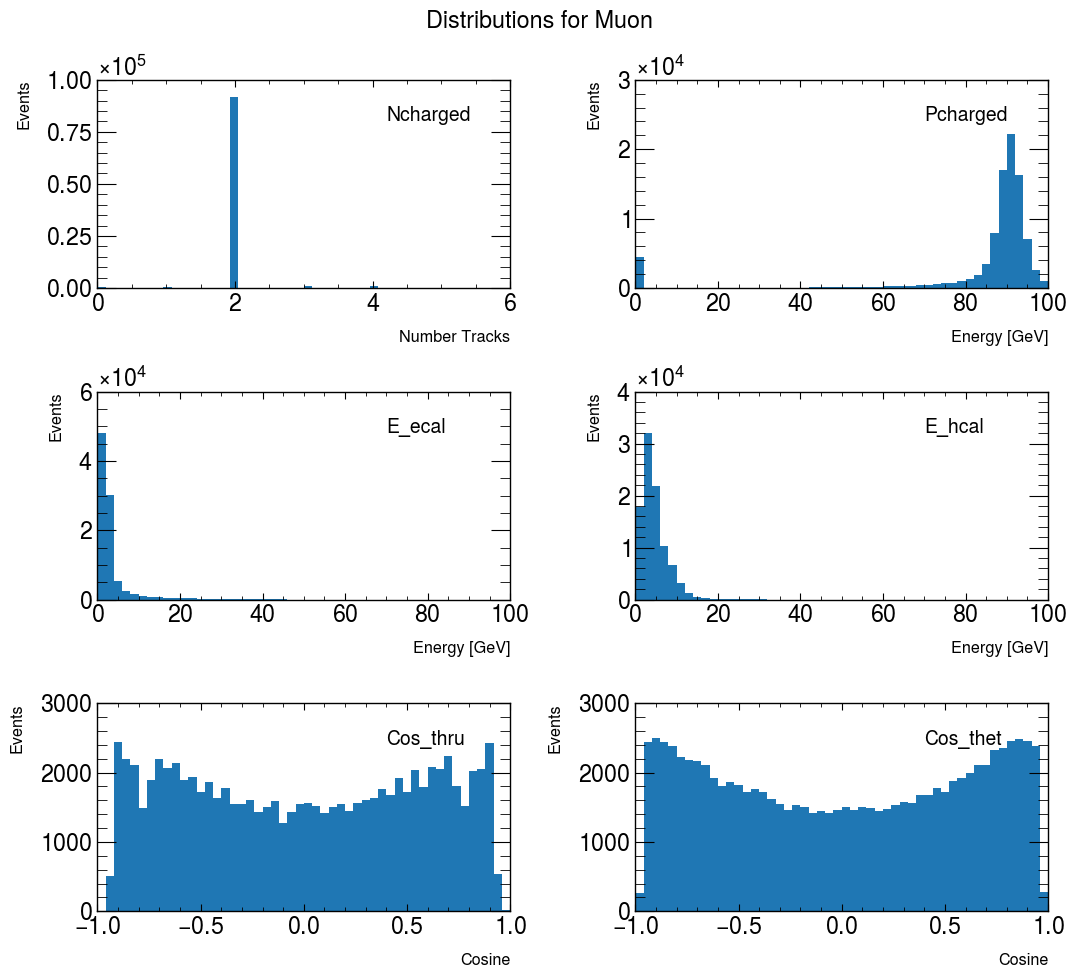

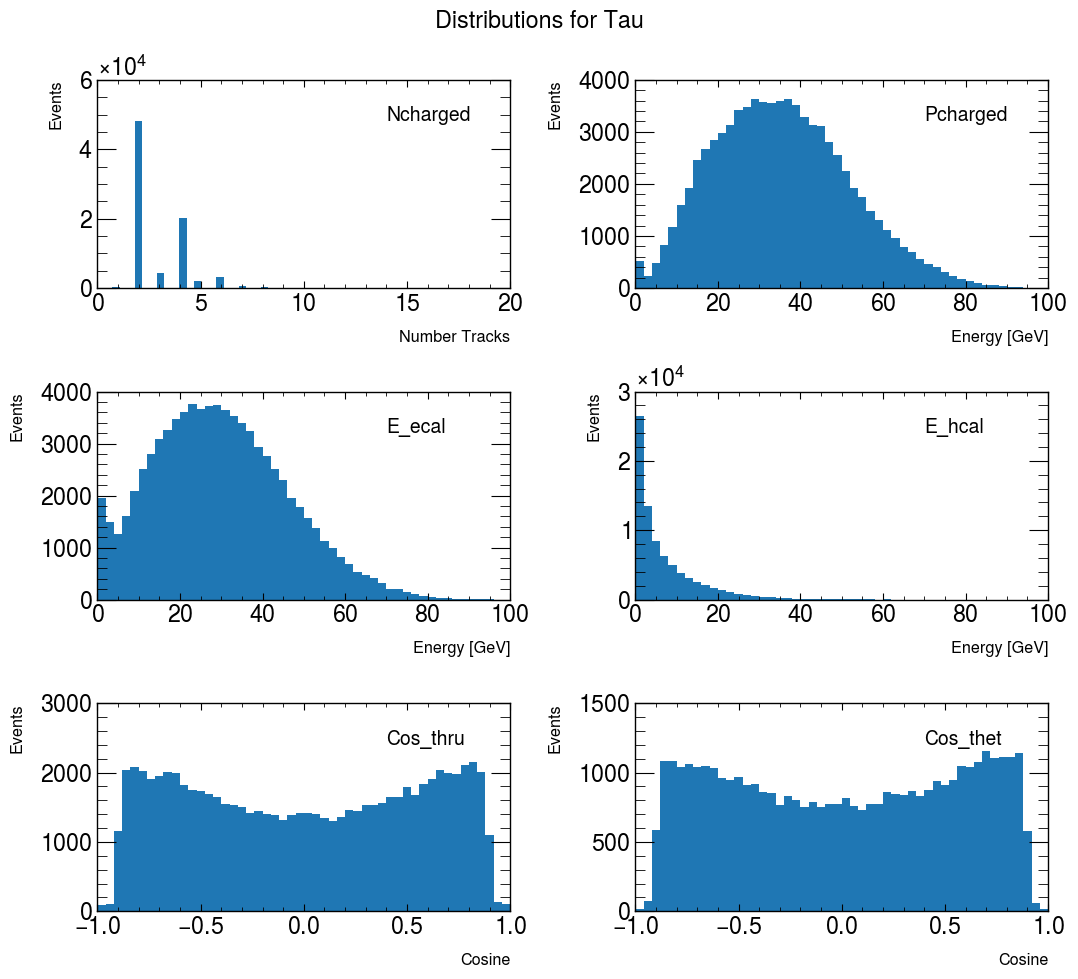

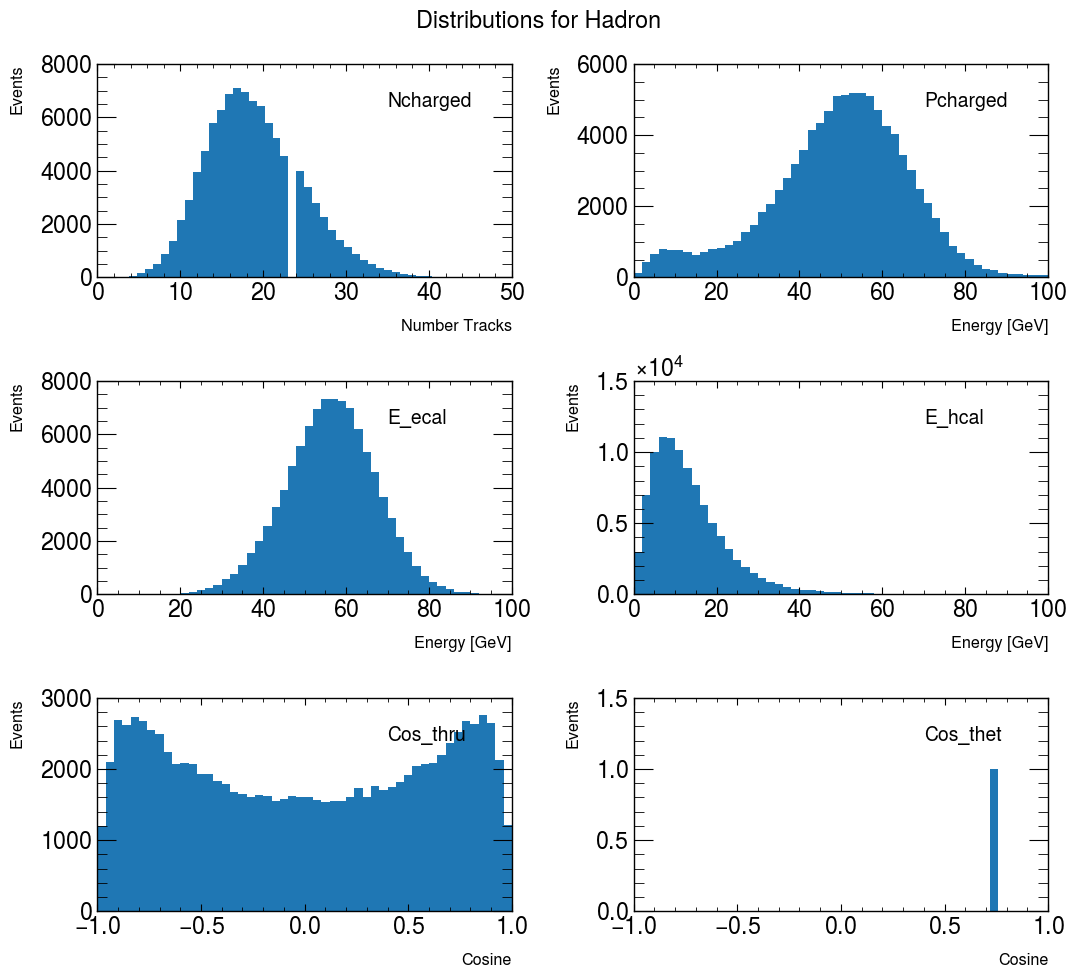

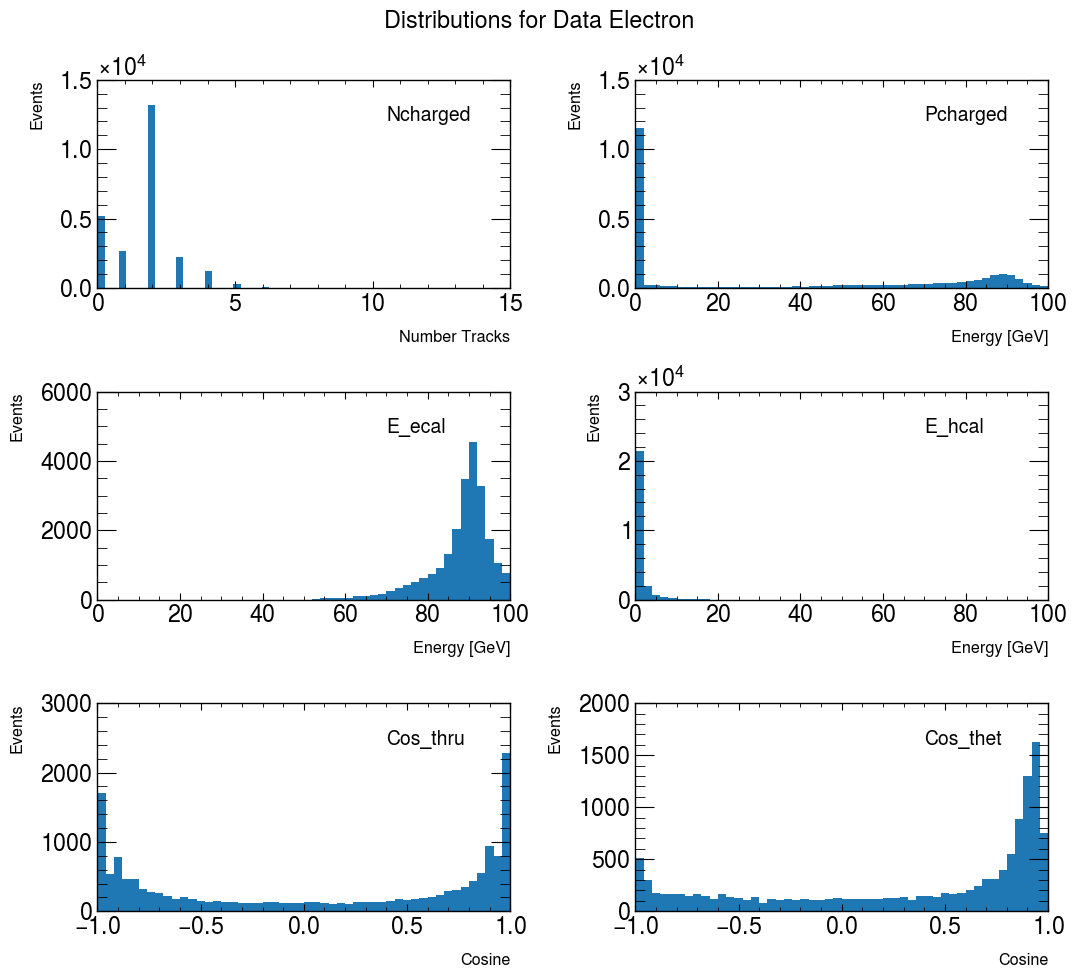

In [13]:
mc_dict = {"Electron":mc_ee,"Muon":mc_mm,"Tau":mc_tt,"Hadron":mc_qq, "Data Electron":data[condition_ee_dat]}
print(len(data[condition_ee_dat]))

for i in mc_dict.keys():
    fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(11,10))
    iax = 0
    jax = 0
    fig.suptitle("Distributions for "+i)
    for j in Nametable.keys():
        if not(Nametable[j] in [2,3,4,5,7,8]): continue
        if Nametable[j] in [3,4,5]: 
            rg = (0,100)
            xlab = "Energy [GeV]"
        if Nametable[j] == 2: 
            rg = (0,100)
            if max(mc_dict[i][:,Nametable[j]])<100: rg=(0,max(mc_dict[i][:,Nametable[j]]))
            xlab = "Number Tracks"
        if Nametable[j] in [7,8]: 
            rg = (-1,1)
            xlab = "Cosine"
        ax[iax][jax].hist(mc_dict[i][:,Nametable[j]],bins=50,range=rg)
        ax[iax][jax].text(0.7,0.8,j,transform=ax[iax][jax].transAxes)
        ax[iax][jax].set_xlabel(xlab,fontsize="small")
        ax[iax][jax].set_ylabel("Events",fontsize="small")
        jax+=1
        if jax>1:
            iax+=1
            jax=0
    plt.tight_layout()

### Statistical uncertainties to the histogram

Think about the statistical uncertainties computed above in 'error_sizes'. 
* **Are these sensible? Why do we use this formula?** (Hint: Making an histogram is, in short, a *counting experiment*. In the limit of large total number of events, the (binomial) probability function limits to the *Poisson distribution*. What is the variance? And the standard deviation?)

### Matrix Inversion
To determine the uncertainties of the matrix elements after the inversion we use Monte Carlo toy experiments. In this context, what are the advantages and disadvantages of this method when compared to analytical expressions? Discuss it briefly.

**References**:
* Propagation of Errors for Matrix Inversion: https://arxiv.org/abs/hep-ex/9909031v1

<IPython.core.display.Math object>

<IPython.core.display.Math object>

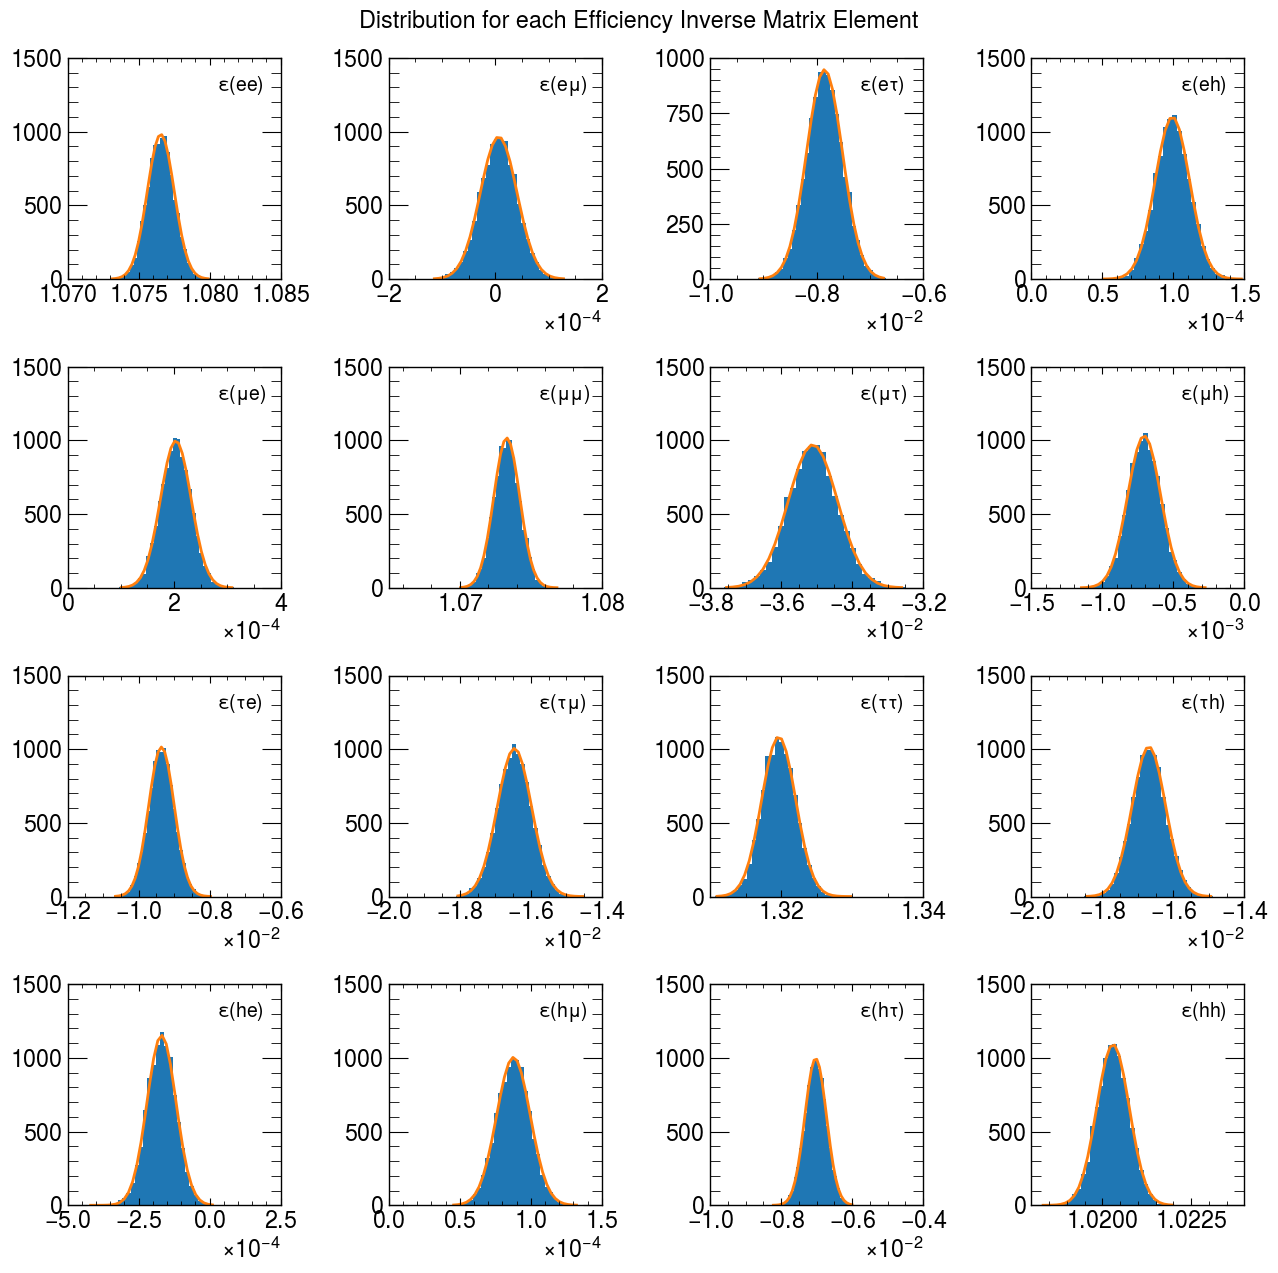

In [14]:
from lmfit import Model
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

gmodel = Model(gauss)
ntoy = 10000
for itoy in range(ntoy):
    aux_inverse = np.linalg.inv(np.random.normal(effcy_matrix,error_matrix))
    if itoy==0: inverse_matrix = aux_inverse
    else: inverse_matrix = np.dstack((inverse_matrix,aux_inverse))


fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(13,13))
error_inverse = np.zeros((4,4))
effcy_inverse = np.linalg.inv(effcy_matrix)
part = [r"$e$",r"$\mu$",r"$\tau$",r"$h$"]
for i in range(4):
    for j in range(4):
        content,bins,_ = ax[i][j].hist(inverse_matrix[i][j],bins=30)
        centers = (bins[1:]+bins[:-1])/2.

        result = gmodel.fit(content, x=centers, A=content.max(), mu=inverse_matrix[i][j].mean(), sigma=np.std(inverse_matrix[i][j]))
        ax[i][j].plot(centers,result.best_fit)
        ax[i][j].text(0.7,0.85,r"$\epsilon($"+part[i]+part[j]+r"$)$",transform=ax[i][j].transAxes)
        error_inverse[i][j] = result.best_values["sigma"]

fig.suptitle("Distribution for each Efficiency Inverse Matrix Element")
plt.tight_layout()

aux_M = sy.Matrix(effcy_inverse)
display(Math("\\epsilon^{-1} =" + sy.latex(sy.N(aux_M,4))))
aux_M = sy.Matrix(error_inverse)
display(Math("\\epsilon^{-1}(\\textrm{error}) =" + sy.latex(sy.N(aux_M,4))))

# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

[0.66894027 2.30288258 0.84411452 0.35444615 0.35342174 0.35854489
 0.40054463 0.39849581 0.39235055 0.3503485  0.36161702 0.39952022
 0.35547164 0.3780076  0.3503485  0.33703219 0.30732325 0.3124453
 0.36264143 0.28683591 0.30629884 0.28683503 0.29400681 0.29093268
 0.27659092 0.28273782 0.32883638 0.29503032 0.30220166 0.28888385
 0.24278574 0.27761533 0.27659135 0.25507869 0.23766331 0.25712751
 0.27863975 0.22639514 0.2561029  0.25507849 0.25507849 0.26020055
 0.24585897 0.28273761 0.26532261 0.24790761 0.26224937 0.23971241
 0.26020055 0.24585881 0.23049263 0.24995646 0.27351793 0.23254148
 0.25405413 0.26942025 0.23868791 0.23356594 0.24790761 0.2561029
 0.2642982  0.28171319 0.29298195 0.29195731 0.23459008 0.280689
 0.30015283 0.32473823 0.29400636 0.27966416 0.2888843  0.30834766
 0.30220166 0.32678755 0.34522645 0.37698376 0.38312965 0.3401044
 0.37595992 0.41181315 0.40259346 0.43742476 0.47635104 0.47942427
 0.50503454 0.55830561 0.60235357 0.69147731 0.63206341 0.76113725


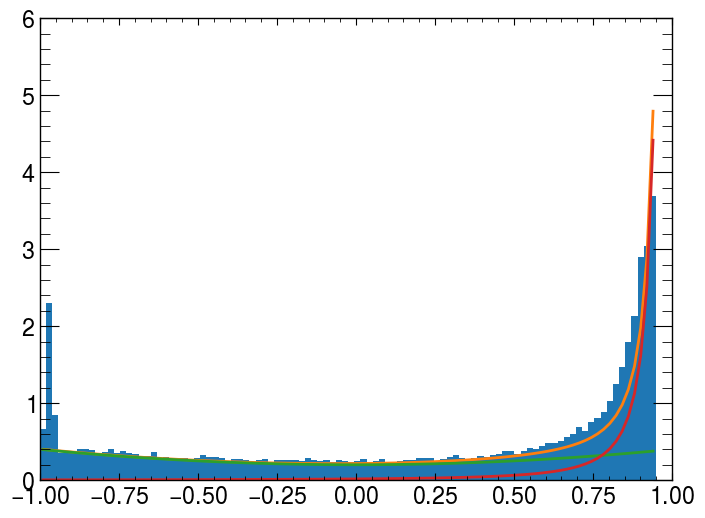

In [15]:
content,bins,_ = plt.hist(mc_ee[:,Nametable["Cos_thet"]],range=(-1,0.95),bins=100,density=True)

print(content,bins)
def dxsec_cos(x,A,B):
    return A*(1+x**2) + B/(1-x)**2

centers = 0.5*(bins[1:]+bins[:-1])
gmodel = Model(dxsec_cos)
result = gmodel.fit(content,x=centers,A=0.2,B=0.015)

plt.plot(centers,result.best_fit)
plt.plot(centers,dxsec_cos(centers,result.best_values["A"],0))
plt.plot(centers,dxsec_cos(centers,0,result.best_values["B"]))
# plt.plot(centers,dxsec_cos(centers,1e4,0))
# plt.plot(centers,dxsec_cos(centers,0,10))

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [57]:
def calc_errfit(xdata,ydata,yerr):
    gmodel = Model(relativistic_breit_wigner)

    ntoy = 1000
    mfits = np.array([])
    gammafits = np.array([])
    for i in range(ntoy):
        toy_ydata = np.random.normal(ydata,yerr)
        result = gmodel.fit(toy_ydata,x=xdata,resonance_mass=91.18,width=2.49,normalization=10)
        mfits = np.append(mfits,result.best_values["resonance_mass"])
        gammafits = np.append(gammafits,result.best_values["width"])

    gmodel = Model(gauss)
    content,bins = np.histogram(mfits,bins=30)
    centers = 0.5*(bins[1:]+bins[:-1])
    result = gmodel.fit(content, x=centers,A=10,mu=mfits.mean(),sigma=np.std(mfits))
    err_m = result.best_values["sigma"]

    content,bins = np.histogram(gammafits,bins=30)
    centers = 0.5*(bins[1:]+bins[:-1])
    result = gmodel.fit(content, x=centers,A=10,mu=gammafits.mean(),sigma=np.std(gammafits))
    err_g = result.best_values["sigma"]

    return err_m,err_g

(0.04272833039571889, 0.10311424155103514)

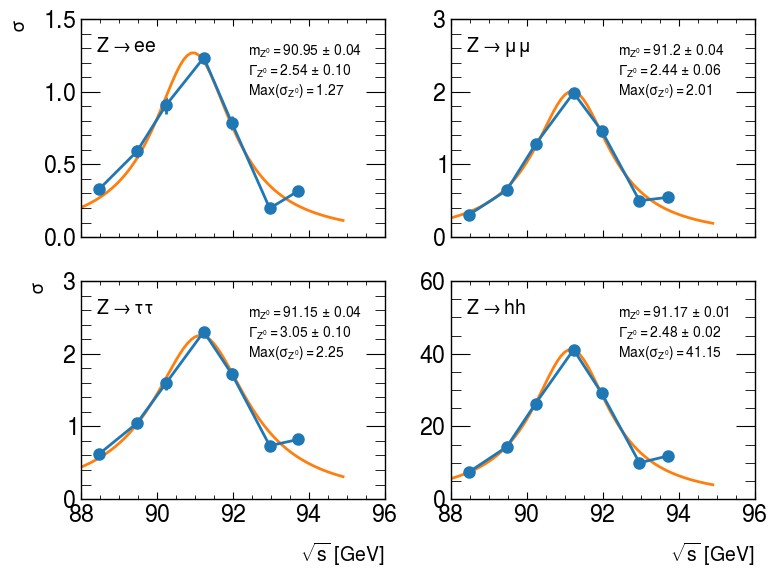

[0.17837776 0.26554496 0.3813529  0.32059775 0.39052132 0.16415784
 0.16891843]


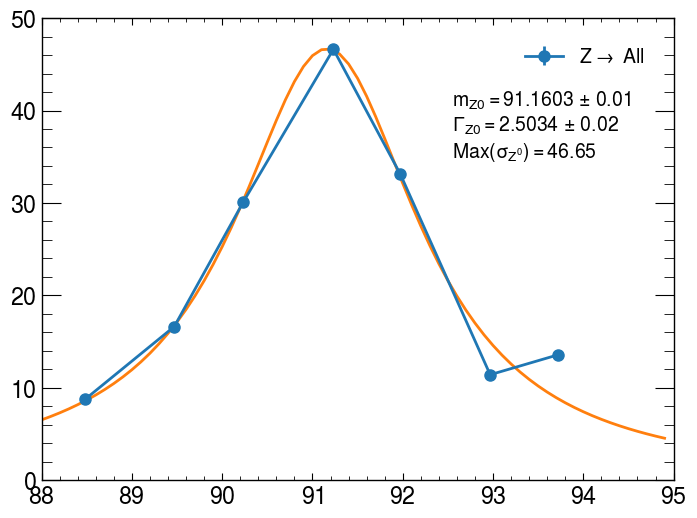

In [87]:
xs_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                   'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08],
                   'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                      }
Lumicsv = np.genfromtxt('./opal_data/lumi_files/daten_5.csv', delimiter=',', skip_header=1,names=["meanenergy","lumi","stat","sys","all"])

# s_channel = (data[:,Nametable["Cos_thet"]]<=-0.95) & (data[:,Nametable["Cos_thet"]]>=-1.5)
s_channel = data[:,Nametable["Cos_thet"]]<=0.
conditions_data = [condition_ee_dat&s_channel,condition_mm_dat,condition_tt_dat,condition_hh_dat]
Nevents = np.zeros((4,7))
xsec_error = np.zeros((4,7))
xsec = np.zeros((4,7))
c1 = np.array([np.histogram(data[conditions_data[k]][:,Nametable["E_lep"]],bins=7)[0] for k in range(4)])
#c1 = c1 - 
# c2 = np.array([np.histogram(data[conditions_data[k]][:,Nametable["E_lep"]],bins=7)[1] for k in range(4)])
for i in range(4):
    for j in range(7):
        Nevents[i][j] = effcy_inverse[i].dot(c1[:,j])
        aux_err1 = np.array([effcy_inverse[i][k]*c1[:,j][k]*np.sqrt( (error_inverse[i][k]/effcy_inverse[i][k])**2 + 1./c1[:,j][k] ) for k in range(4)])
        aux_err = np.sqrt(sum(aux_err1**2))
        xsec[i][j] = Nevents[i][j]/Lumicsv["lumi"][j] + xs_corrections[list(xs_corrections.keys())[1+(i+1)//4]][j]
        xsec_error[i][j] = xsec[i][j]*np.sqrt( (aux_err/Nevents[i][j])**2 + (Lumicsv["all"][j]/Lumicsv["lumi"][j])**2 )

def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

gmodel = Model(relativistic_breit_wigner)

fig,ax = plt.subplots(nrows=2,ncols=2,sharex=True)
MaximumXsec, ZMass, Zwidth = [], [], []

for i in range(4):
    ax[i//2][i%2].errorbar(x=Lumicsv["meanenergy"],y=xsec[i],yerr=xsec_error[i],fmt="o",ls="-",label=r"Z$\rightarrow$"+part[i]*2)
    ax[i//2][i%2].text(0.05,0.85,r"$Z\rightarrow$"+part[i]*2,transform=ax[i//2][i%2].transAxes)
    result = gmodel.fit(xsec[i],x=Lumicsv["meanenergy"],resonance_mass=92,width=3,normalization=10)
    ax[i//2][i%2].plot(np.arange(88,95,.1),relativistic_breit_wigner(np.arange(88,95,.1),*result.best_values.values()))
    MaximumXsec.append(max(relativistic_breit_wigner(np.arange(88,95,.1),*result.best_values.values())))
    ZMass.append(np.around(result.best_values["resonance_mass"],4))
    Zwidth.append(np.around(result.best_values["width"],4))
    fit_errors = calc_errfit(Lumicsv["meanenergy"],xsec[i],xsec_error[i])
    text_val = r"$m_{Z^{0}}=$" + str(np.around(result.best_values["resonance_mass"],2)) + r" $\pm$ {:.2f}".format(fit_errors[0]) + "\n" + r"$\Gamma_{Z^{0}}=$" +  str(np.around(result.best_values["width"],2)) + r" $\pm$ {:.2f}".format(fit_errors[1]) + "\n" + r"$Max(\sigma_{Z^{0}})=$" + str(round(MaximumXsec[i],2))
    ax[i//2][i%2].text(0.55,0.65,text_val,transform=ax[i//2][i%2].transAxes, fontsize=10)

ax[0][0].set_ylabel(r"$\sigma$",fontsize="medium")
ax[1][0].set_ylabel(r"$\sigma$",fontsize="medium")
ax[1][0].set_xlabel(r"$\sqrt{s}$ [GeV]",fontsize="medium")
ax[1][1].set_xlabel(r"$\sqrt{s}$ [GeV]",fontsize="medium")
plt.tight_layout()
plt.show()

ErrorAll = np.sqrt(np.sum(np.array([xsec_error[i]**2 for i in range(4)]),axis=0))
print(ErrorAll)
Totalxsec = np.sum(xsec,axis=0)
plt.errorbar(x=Lumicsv["meanenergy"],y=Totalxsec,yerr=ErrorAll,fmt="o",ls="-",label=r"Z$\rightarrow$ All")
resultAll = gmodel.fit(Totalxsec,x=Lumicsv["meanenergy"],resonance_mass=92,width=3,normalization=10)
plt.plot(np.arange(88,95,.1),relativistic_breit_wigner(np.arange(88,95,.1),*resultAll.best_values.values()))
MaximumXsecAll = max(relativistic_breit_wigner(np.arange(88,95,.1),*resultAll.best_values.values()))
fit_errors = calc_errfit(Lumicsv["meanenergy"],Totalxsec,ErrorAll)
text_val = r"$m_{Z0}=$" + str(np.around(resultAll.best_values["resonance_mass"],4)) + r" $\pm$ {:.2f}".format(fit_errors[0]) + "\n" + r"$\Gamma_{Z0}=$" + str(np.around(resultAll.best_values["width"],4)) + r" $\pm$ {:.2f}".format(fit_errors[1]) + "\n" + r"$Max(\sigma_{Z^{0}})=$" + str(round(MaximumXsecAll,2))
plt.text(0.65,0.70,text_val,transform=plt.gca().transAxes)

plt.legend()
plt.show()


In [0]:
# Number of Generations

# Exercise 3: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

[ 6.18298897e-04  7.43614119e+00 -9.94462748e-02 -2.20173700e-03]
[        nan 11.60996347         nan         nan]
[        nan 16.69803535         nan         nan]
[        nan 59.43792517         nan         nan]
[        nan 19.76391071         nan         nan]
[        nan 15.48046434         nan         nan]
[ 2.04991894e-04  1.76050841e+01 -3.51113848e-02 -7.14838163e-04]
[0.22193368 0.48493849 0.88578775 1.38071373 0.95176216 0.4096233
 0.42061591]
[ 6.18298897e-04  7.95993388e+00 -9.94462748e-02 -2.20173700e-03]
[        nan 10.35084012         nan         nan]
[        nan 15.92082447         nan         nan]
[        nan 54.33428423         nan         nan]
[        nan 18.40515938         nan         nan]
[       nan 11.1026904        nan        nan]
[ 2.04991894e-04  1.40360375e+01 -3.51113848e-02 -7.14838163e-04]
[0.23812638 0.43044075 0.83950823 1.24251268 0.85864585 0.23606485
 0.27240782]
[ 6.18298897e-04  7.43614119e+00 -9.94462748e-02 -2.20173700e-03]
[        nan 11

<ipython-input-84-b3e83979cbcd>:18: RuntimeWarning: divide by zero encountered in true_divide
  aux_err1 = np.array([effcy_inverse[i][k]*c1[:,j][k]*np.sqrt( (error_inverse[i][k]/effcy_inverse[i][k])**2 + 1./c1[:,j][k] ) for k in range(4)])
<ipython-input-84-b3e83979cbcd>:18: RuntimeWarning: invalid value encountered in double_scalars
  aux_err1 = np.array([effcy_inverse[i][k]*c1[:,j][k]*np.sqrt( (error_inverse[i][k]/effcy_inverse[i][k])**2 + 1./c1[:,j][k] ) for k in range(4)])


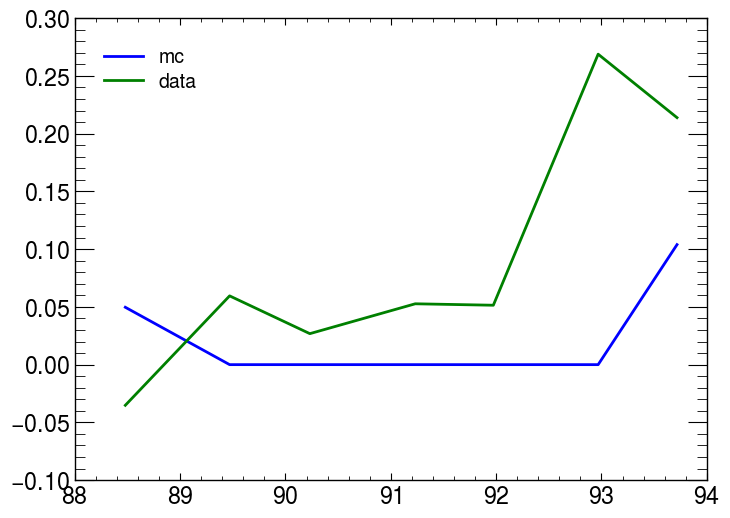

In [84]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

def CalcXSec(dataarray, muon_condition,Foward=True):
    s_channel = dataarray[:,Nametable["Cos_thet"]]<=0.
    FOW_BACK_condition = np.bitwise_and(dataarray[:,Nametable["Cos_thet"]]<0, muon_condition)
    if Foward:
        FOW_BACK_condition = np.bitwise_and(dataarray[:,Nametable["Cos_thet"]]>0, muon_condition)
    conditions_data = [True,FOW_BACK_condition,True,True] #ignore everything exept muons
    Nevents = np.zeros((4,7))
    xsec_error = np.zeros((4,7))
    xsec = np.zeros((4,7))
    c1 = np.array([np.histogram(dataarray[conditions_data[k]][:,Nametable["E_lep"]],bins=7)[0] for k in range(4)])
    for i in range(4):
        for j in range(7):
            if i==1:
                Nevents[i][j] = effcy_inverse[i].dot(c1[:,j])
                aux_err1 = np.array([effcy_inverse[i][k]*c1[:,j][k]*np.sqrt( (error_inverse[i][k]/effcy_inverse[i][k])**2 + 1./c1[:,j][k] ) for k in range(4)])
                print(aux_err1)
                aux_err = np.sqrt(sum(aux_err1**2))
                xsec[i][j] = Nevents[i][j]/Lumicsv["lumi"][j] + xs_corrections[list(xs_corrections.keys())[1+(i+1)//4]][j] + radiation_corrections["correction"][j]
                xsec_error[i][j] = xsec[i][j]*np.sqrt( (aux_err/Nevents[i][j])**2 + (Lumicsv["all"][j]/Lumicsv["lumi"][j])**2 )

    return xsec[1],xsec_error[1]

print(CalcXSec(data, condition_mm_dat)[0])
print(CalcXSec(data, condition_mm_dat, False)[0])
Foward_data, Foward_err_data= CalcXSec(data, condition_mm_dat)
Backward_data, Backward_err_data = CalcXSec(data, condition_mm_dat,False)
Asymmetry_data = [(Foward_data[i] - Backward_data[i])/ (Foward_data[i] + Backward_data[i]) for i in range(7)]

Foward_mc, Foward_err_mc= CalcXSec(mc_all, condition_mm)
Backward_mc, Backward_err_mc = CalcXSec(mc_all, condition_mm,False)
Asymmetry_mc = [(Foward_mc[i] - Backward_mc[i])/ (Foward_mc[i] + Backward_mc[i]) for i in range(7)]
print(Asymmetry_mc)

plt.plot(Lumicsv["meanenergy"],Asymmetry_mc, color="b", label="mc")
plt.plot(Lumicsv["meanenergy"],Asymmetry_data, color="g", label="data" )
plt.legend()

print(Asymmetry_data[3])
print(r"$A_{FB}$ = " + str(Asymmetry_data[3]))
print(r"$\dfrac{v}{a}$ = " + str(np.sqrt(Asymmetry_data[3]/3)))
print(r"sin$^2\theta_W$ = " + str( (1-np.sqrt(Asymmetry_data[3]/3))/4 ))
print(r"$\theta_W$ = " + str( np.arcsin( np.sqrt( (1 - np.sqrt(Asymmetry_data[3]/3))/4 ) )*180/np.pi )  )
print(Backward_err_data)


# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.

In [88]:
#MaximumXsec, ZMass, Zwidth
print("cross section:")
print("Electron/Muon: {:.2f}".format(MaximumXsec[0]/MaximumXsec[1]))
print("Electron/Tau: {:.2f}".format(MaximumXsec[0]/MaximumXsec[2]))
print("Muon/Tau: {:.2f}".format(MaximumXsec[1]/MaximumXsec[2]))

print("Zwidth:")
print("Electron/Muon: {:.2f}".format(Zwidth[0]/Zwidth[1]))
print("Electron/Tau: {}".format(Zwidth[0]/Zwidth[2]))
print("Muon/Tau: {}".format(Zwidth[1]/Zwidth[2]))


cross section:
Electron/Muon: 0.6310939536054727
Electron/Tau: 0.5627324134023035
Muon/Tau: 0.891677713258674
Zwidth:
Electron/Muon: 1.0389514642637723
Electron/Tau: 0.8316993999803272
Muon/Tau: 0.8005180497721237
